# 선형회귀

현대 중공업과 계약을 맺어 일부 선박에 대한 예측 모델을 구축하게됐습니다. 현대 중공업은 세계 최대의 선박 제조업체 중 하나로 유람선을 제작하고 있습니다.
당신은 선박에 필요한 선원 수를 정확하게 예측할 수 있도록 울산에있는 본사에 도착했습니다.
그들은 현재 새로운 선박을 건조하고 있으며 예측 모델을 만들고, 이를 사용하여 선박에 필요한 승무원 수를 예측하기를 원합니다.

지금까지의 데이터는 다음과 같습니다.

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
위 데이터는 "cruise_ship_info.csv"라는 csv 파일에 저장됩니다. 귀하의 임무는 향후 선박에 필요한 선원 수를 예측하는 데 도움이되는 회귀 모델을 만드는 것입니다. 고객은 또한 특정 크루즈 라인이 허용되는 승무원 수에 차이가 있음을 발견 했으므로 분석에 포함하는 것이 가장 중요한 기능이라고 언급했습니다!

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("./data/cruise_ship_info_example.csv").iloc[:, 1:]
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,NaN
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,NaN
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [3]:
ndf = df[df["crew"].isna() == False].reset_index(drop = True)

In [4]:
ndf = ndf[ndf["Cruise_line"].isin(["Crystal", "Oceania", "Orient", "P&O", "Windstar"]) == False]

In [5]:
ndf = ndf.drop(ndf["crew"].idxmax()).reset_index(drop = True)

In [6]:
ndf_line = ndf["Cruise_line"]

In [7]:
y = ndf["crew"]

In [8]:
ndf = ndf.iloc[:, 2:-1]

In [9]:
pd.concat([ndf, y], axis = 1).corr()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.603655,-0.522550,-0.506521,-0.538381,-0.256638,-0.549574
Tonnage,-0.603655,1.000000,0.945376,0.931081,0.956573,0.031930,0.946477
passengers,-0.522550,0.945376,1.000000,0.902300,0.982007,-0.217919,0.926718
length,-0.506521,0.931081,0.902300,1.000000,0.921220,-0.043696,0.943390
cabins,-0.538381,0.956573,0.982007,0.921220,1.000000,-0.178752,0.958487
passenger_density,-0.256638,0.031930,-0.217919,-0.043696,-0.178752,1.000000,-0.088696
crew,-0.549574,0.946477,0.926718,0.943390,0.958487,-0.088696,1.000000


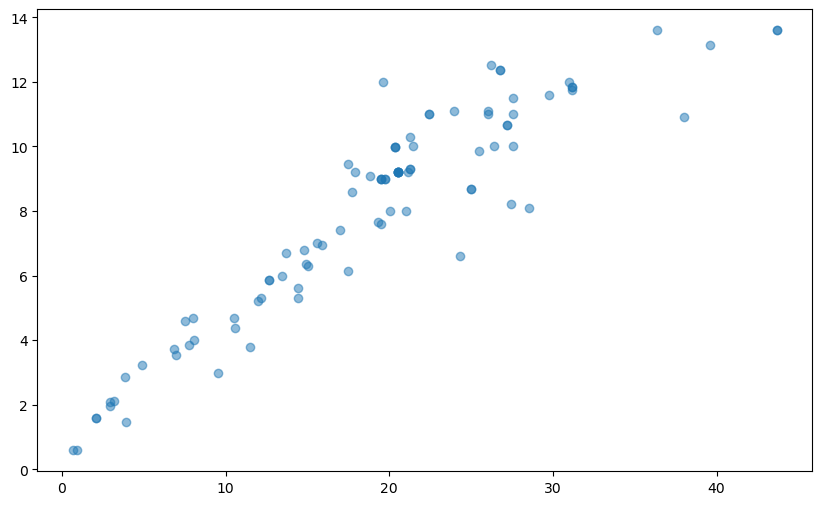

In [10]:
plt.figure(figsize = (10, 6))

plt.scatter(ndf["passengers"], y, alpha = 0.5)
plt.show()

In [11]:
ss = StandardScaler()

In [12]:
ndf_ss = pd.DataFrame(ss.fit_transform(ndf), columns = ndf.columns)

In [13]:
x = pd.concat([ndf_ss, pd.get_dummies(ndf_line, dtype = "int64")], axis = 1)

In [14]:
x.head()

,Age,Tonnage,passengers,length,cabins,passenger_density,Azamara,Carnival,Celebrity,Costa,...,Disney,Holland_American,MSC,Norwegian,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star
0,-1.302979,-1.164286,-1.292660,-1.242727,-1.310106,0.383834,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.159866,0.760487,0.794251,0.390072,0.945371,-0.137323,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.824796,-0.078629,0.162178,0.187342,0.242577,-0.632910,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.106106,-0.078629,0.162178,0.187342,0.242577,-0.632910,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.957782,-0.078629,0.166463,0.187342,0.247247,-0.640216,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 7)

In [16]:
lr = LinearRegression()

In [17]:
lr.fit(x_train, y_train)

LinearRegression()

In [18]:
lr.score(x_train, y_train)

0.9765926498283312

In [19]:
lr.score(x_test, y_test)

0.9768681759963481

In [20]:
y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mse

0.23886130357434765

In [21]:
model = sm.OLS(y_train, x_train)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crew   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     120.8
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           6.43e-38
Time:                        12:41:06   Log-Likelihood:                -55.546
No. Observations:                  75   AIC:                             151.1
Df Residuals:                      55   BIC:                             197.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Age                  -0.0015      0.138     -0.011      0.992      -0.279       0.276
Tonnage               0.8619      0.455      1.894      0.064      -0.050       1.774
passengers           -0.7123      0.480     -1.485      0.143      -1.673       0.249
length                1.1501      0.261      4.399      0.000       0.626       1.674
cabins                2.3477      0.526      4.461      0.000       1.293       3.402
passenger_density    -0.1630      0.172     -0.950      0.346      -0.507       0.181
Azamara               8.1984      0.703     11.654      0.000       6.789       9.608
Carnival              8.0551      0.217     37.066      0.000       7.620       8.491
Celebrity             8.6454      0.317     27.308      0.000       8.011       9.280
Costa                 7.6026      0.228     33.295      0.000       7.145       8.060
Cunard                8.2883      0.673     12.323      0.000       6.940       9.636
Disney            -4.409e-15    2.5e-16    -17.625      0.000   -4.91e-15   -3.91e-15
Holland_American      7.3751      0.303     24.371      0.000       6.769       7.982
MSC                   7.6884      0.300     25.626      0.000       7.087       8.290
Norwegian             8.1247      0.215     37.838      0.000       7.694       8.555
Princess              8.0407      0.204     39.441      0.000       7.632       8.449
Regent_Seven_Seas     8.7257      0.509     17.154      0.000       7.706       9.745
Royal_Caribbean       6.6174      0.246     26.850      0.000       6.124       7.111
Seabourn              8.8089      0.543     16.234      0.000       7.721       9.896
Silversea             8.6457      0.558     15.507      0.000       7.528       9.763
Star                  9.7476      0.398     24.513      0.000       8.951      10.544
==============================================================================
Omnibus:                        0.985   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                0.431
Skew:                          -0.041   Prob(JB):                        0.806
Kurtosis:                       3.362   Cond. No.                     1.34e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["feature"] = x.columns
vif.round(1)

,VIF_Factor,feature
0,3.0,Age
1,47.8,Tonnage
2,52.0,passengers
3,10.9,length
4,60.4,cabins
5,5.4,passenger_density
6,1.2,Azamara
7,1.4,Carnival
8,1.1,Celebrity
9,1.0,Costa


In [23]:
drop_list = ["Age", "passenger_density"]

In [24]:
new_x = sm.add_constant(x_train.drop(drop_list, axis = 1))
model = sm.OLS(y_train, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crew   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     137.2
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           7.82e-40
Time:                        12:41:06   Log-Likelihood:                -56.251
No. Observations:                  75   AIC:                             148.5
Df Residuals:                      57   BIC:                             190.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5953      0.097     78.561      0.000       7.402       7.789
Tonnage               0.5482      0.325      1.685      0.097      -0.103       1.200
passengers           -0.4350      0.389     -1.117      0.268      -1.215       0.345
length                1.1343      0.248      4.581      0.000       0.639       1.630
cabins                2.3671      0.519      4.560      0.000       1.328       3.407
Azamara               0.5414      0.567      0.956      0.343      -0.593       1.676
Carnival              0.4888      0.249      1.960      0.055      -0.011       0.988
Celebrity             1.0710      0.303      3.539      0.001       0.465       1.677
Costa                 0.0244      0.238      0.103      0.919      -0.452       0.501
Cunard                0.7539      0.473      1.594      0.116      -0.193       1.701
Disney            -1.449e-16   1.52e-16     -0.952      0.345    -4.5e-16     1.6e-16
Holland_American     -0.2070      0.288     -0.718      0.476      -0.784       0.370
MSC                   0.1576      0.284      0.554      0.581      -0.412       0.727
Norwegian             0.5833      0.224      2.610      0.012       0.136       1.031
Princess              0.4681      0.212      2.208      0.031       0.044       0.893
Regent_Seven_Seas     0.8737      0.394      2.217      0.031       0.085       1.663
Royal_Caribbean      -0.9411      0.258     -3.642      0.001      -1.459      -0.424
Seabourn              1.0103      0.459      2.203      0.032       0.092       1.929
Silversea             0.6776      0.376      1.802      0.077      -0.075       1.431
Star                  2.0931      0.345      6.068      0.000       1.402       2.784
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.660
Skew:                           0.034   Prob(JB):                        0.719
Kurtosis:                       3.454   Cond. No.                     3.74e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.09e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [25]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,VIF_Factor,feature
0,0.0,const
1,23.3,Tonnage
2,33.8,passengers
3,13.0,length
4,58.3,cabins
5,inf,Azamara
6,inf,Carnival
7,inf,Celebrity
8,inf,Costa
9,inf,Cunard


In [26]:
lr.fit(new_x, y_train)

LinearRegression()

In [27]:
lr.score(new_x, y_train)

0.9761483570739663

In [28]:
lr.score(sm.add_constant(x_test.drop(drop_list, axis = 1)), y_test)

0.979484572195629

In [29]:
y_pred = lr.predict(sm.add_constant(x_test.drop(drop_list, axis = 1)))
mse = mean_squared_error(y_test, y_pred)
mse

0.21184416014767551

In [30]:
fin_x = pd.concat([new_x, sm.add_constant(x_test.drop(drop_list, axis = 1))], axis = 0)

In [31]:
fin_y = pd.concat([y_train, y_test])

In [32]:
lr.fit(fin_x, fin_y)

LinearRegression()

In [33]:
lr.score(fin_x, fin_y)

0.97760029373128

In [34]:
fin_pred = lr.predict(fin_x)

In [35]:
mse = mean_squared_error(fin_y, fin_pred)
mse

0.24412208841752306

In [36]:
df_pred = df[df["crew"].isna()]

In [37]:
df_pred_line = df_pred["Cruise_line"]

In [38]:
df_pred2 = df_pred.iloc[:, 2:-1]

In [39]:
df_pred2_ss = pd.DataFrame(ss.fit_transform(df_pred2), columns = df_pred2.columns)

In [40]:
df_pred3 = pd.concat([df_pred2_ss, pd.get_dummies(df_pred_line, dtype = "int64").reset_index(drop = True)], axis = 1)

In [41]:
df_pred3 = sm.add_constant(df_pred3.drop(drop_list, axis = 1))

In [42]:
df_pred3["Crystal"] = 0
df_pred3["Oceania"] = 0
df_pred3["Orient"] = 0
df_pred3["P&O"] = 0
df_pred3["Windstar"] = 0

In [43]:
df_pred4 = df_pred3.iloc[:, [df_pred3.columns.tolist().index(i) for i in new_x.columns.tolist()]]

In [44]:
lr.predict(df_pred4)

array([ 3.56177504,  6.39340204, 11.63131784,  6.34178591,  8.79154449,
       11.96418347, 10.04075683, 11.97118422,  9.17518888, 10.231868  ,
        9.52333041,  5.68892292,  9.50827941, 10.07478291,  9.5607985 ,
        6.11630911,  5.37754867,  8.64552789,  5.96614689,  5.38135822,
        6.34018221,  8.64788716,  7.09408775,  4.5426594 ,  7.087087  ,
        8.94501797,  8.85882718,  7.20605883, 11.87022864, 11.13255866,
        3.55890759,  4.98945251,  3.82915789,  8.41834164,  4.81677878,
        7.7086541 ,  7.00517014,  8.03200632, 11.80751779, 18.77720891,
        7.67351216,  8.41834164,  6.88646173, 11.80751779,  1.57718552,
        2.94510663,  1.25468483,  6.96464803])